In [1]:
# installing keras tuner
!pip install -q keras-tuner

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import RMSprop, Adam
import keras_tuner as kt
from tensorflow.keras.utils import set_random_seed
set_random_seed(20)

In [3]:
# loading the dataset
df = pd.read_csv('/content/diabetes_dataset.csv')
df.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,0,33.6,0.627,50,1
1,1,85,0,26.6,0.351,31,0
2,8,183,0,23.3,0.672,32,1
3,1,89,94,28.1,0.167,21,0
4,0,137,168,43.1,2.288,33,1


In [4]:
# getting the info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   Insulin                   768 non-null    int64  
 3   BMI                       768 non-null    float64
 4   DiabetesPedigreeFunction  768 non-null    float64
 5   Age                       768 non-null    int64  
 6   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 42.1 KB


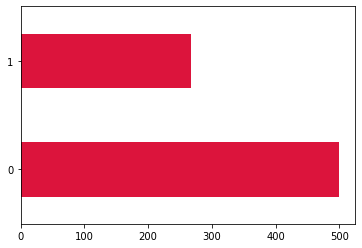

In [5]:
# getting the value count of target; 0 = No, 1 = yes
df['Outcome'].value_counts().plot.barh(color='crimson');

In [6]:
# creating X & y
X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

In [7]:
# scaling the X
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# splitting the data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle=True, random_state=42)

In [9]:
# defining the search space for hyperparameters

def model_builder(hp):

  model = Sequential()
  
  counter = 0

  for i in range(hp.Int(name='layers', min_value=2, max_value=6)):

    # input layer
    if counter == 0:
      model.add(Dense(
          units=hp.Int('units' + str(i),  min_value=6, max_value=72, step=6), 
          activation=hp.Choice('activation' + str(i), values=['relu', 'tanh']),input_dim=6))
      model.add(BatchNormalization())
      model.add(Dropout(hp.Float('drop_rate' + str(i), min_value=0.1, max_value=0.9, step=0.1)))
    
    # hidden layers
    else:
      model.add(Dense(
          units=hp.Int('units' + str(i),  min_value=6, max_value=72, step=6), 
          activation=hp.Choice('activation' + str(i), values=['relu', 'tanh'])))
      model.add(BatchNormalization())
      model.add(Dropout(hp.Float('drop_rate' + str(i), min_value=0.1, max_value=0.9, step=0.1)))
    
    counter += 1

  # output layer
  model.add(Dense(1, activation='sigmoid'))

  # compilation  
  model.compile(optimizer=hp.Choice('optimizer' + str(i), values=['adam', 'rmsprop']), 
                loss='binary_crossentropy', metrics=['accuracy'])
  
  # returning the model
  return model

In [10]:
# creating a tuner object
tuner = kt.RandomSearch(hypermodel=model_builder, objective='val_accuracy', 
                      max_trials=10, directory='mydir', project_name='diabetes', seed=420)

In [11]:
# getting the hps summary
tuner.search_space_summary()

Search space summary
Default search space size: 24
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 72, 'step': 6, 'sampling': 'linear'}
activation0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
drop_rate0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 72, 'step': 6, 'sampling': 'linear'}
activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
drop_rate1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
optimizer1 (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}
units2 (Int)
{'default': None, 'condit

In [12]:
# searching for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

In [13]:
# checking the results 
tuner.results_summary(num_trials=1)

Results summary
Results in mydir/diabetes
Showing 1 best trials
Trial summary
Hyperparameters:
layers: 3
units0: 18
activation0: relu
drop_rate0: 0.1
units1: 30
activation1: relu
drop_rate1: 0.30000000000000004
optimizer1: rmsprop
units2: 54
activation2: tanh
drop_rate2: 0.1
optimizer2: rmsprop
Score: 0.78125


In [14]:
# fetching the best model
model = tuner.get_best_models()[0]

In [15]:
# getting the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                126       
                                                                 
 batch_normalization (BatchN  (None, 18)               72        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                570       
                                                                 
 batch_normalization_1 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30)                0

In [16]:
# model training with the best hyperparameters
history = model.fit(X_train, y_train, epochs=100, initial_epoch=21, validation_data=(X_test, y_test), verbose=0)

In [17]:
# checking the model performance
_, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
_, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Training: {}, Testing: {}'.format(train_accuracy * 100, test_accuracy * 100))

Training: 83.33333134651184, Testing: 72.39583134651184


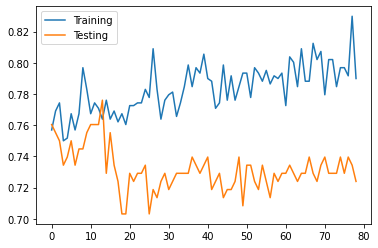

In [18]:
# plotting the accuracy; overfitting
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Testing')
plt.legend();